This is a notebook to explore the trained ANN saved by `create_and_train.py`

In [1]:
try:
    import cPickle as pickle
except:
    import pickle

import numpy as np
import pandas as pd
import matplotlib
# this was required on one of my machines while running in a conda environment
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

import lasagne
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

from sklearn import preprocessing

%matplotlib inline

In [2]:
# recreate the training and test sets.  I have tested this and confirmed
# that it always reproduces the same arrays

# specify the seed for random number generation so we can get consistent
# shuffling and initialized weights
np.random.seed(6509)

# Read the training data for the neural network
# Input data is 250000x4 and output data is 250000x32
X = pd.read_csv('../parameters_250000.txt', sep=' ')
Y = pd.read_csv('../results.txt', sep=' ', index_col=False)
# These functional groups do not exist in my model
Y = Y.drop(['light_aromatic_C-C', 'light_aromatic_methoxyl'], axis=1)
y_columns = Y.columns.values

X = X.values.astype(np.float32)
Y = Y.values.astype(np.float32)

# Shuffle the dataset (because x parameters are varied in a structured way)
combined = np.concatenate((X, Y), axis=1)
np.random.shuffle(combined)

# Separate the data into training (with included validation) and test sets.
# (Validation set is separated from the training set by nolearn)
test_fraction = 0.2
training = combined[:-int(test_fraction * combined.shape[0]), :]
test = combined[-int(test_fraction * combined.shape[0]):, :]

x_train = training[:, :4]
y_train = training[:, 4:]
x_test = test[:, :4]
y_test = test[:, 4:]

# load the full trained network and related scaling objects
with open('ann_objects.pkl', 'rb') as pkl:
    net_objs = pickle.load(pkl)
net = net_objs[0]
x_scaler = net_objs[1]
y_scaler = net_objs[2]

# Standardize the input parameters to have zero mean and unit variance
# x_scaler.transform() can be used later to transform any new data
# x_scaler.inverse_transform() can be used to get the original data back
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)

# Scale the output parameters to lie between 0 and 1
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [3]:
output_col_files = !ls ann_objects-*

# dictionary of nets for each output measure
net_objs = {}
for filename in output_col_files:
    output_col = int(filename.split('-')[1])
    with open(filename, 'rb') as pkl:
        net_objs[output_col] = [filename.split('-')[2].split('.')[0],
                                pickle.load(pkl)[0]]


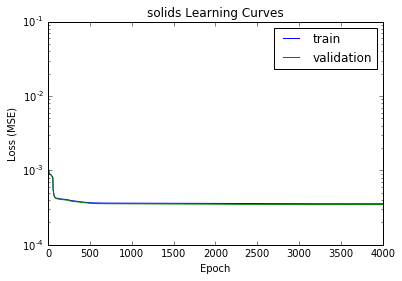

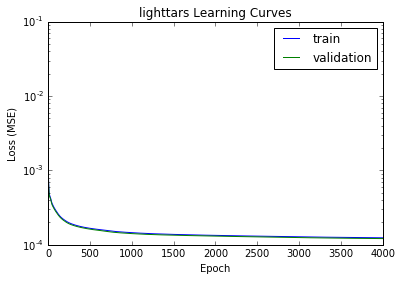

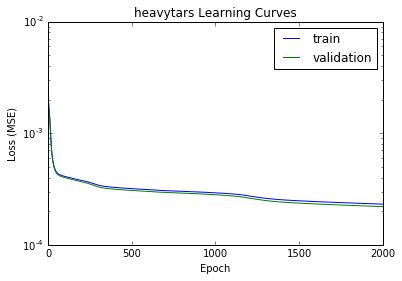

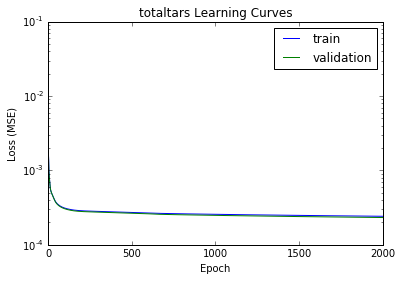

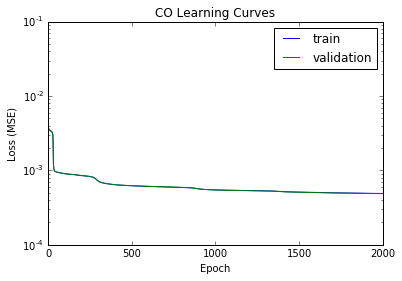

In [4]:
# Plot learning curves for all output measures
for key in net_objs:
    title = net_objs[key][0]
    net = net_objs[key][1]

    # Plot the learning curves
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])

    plt.figure(key)
    plt.plot(train_loss, label='train')
    plt.plot(valid_loss, label='validation')
    plt.legend(loc=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.yscale('log')
    plt.title('%s Learning Curves' % title)


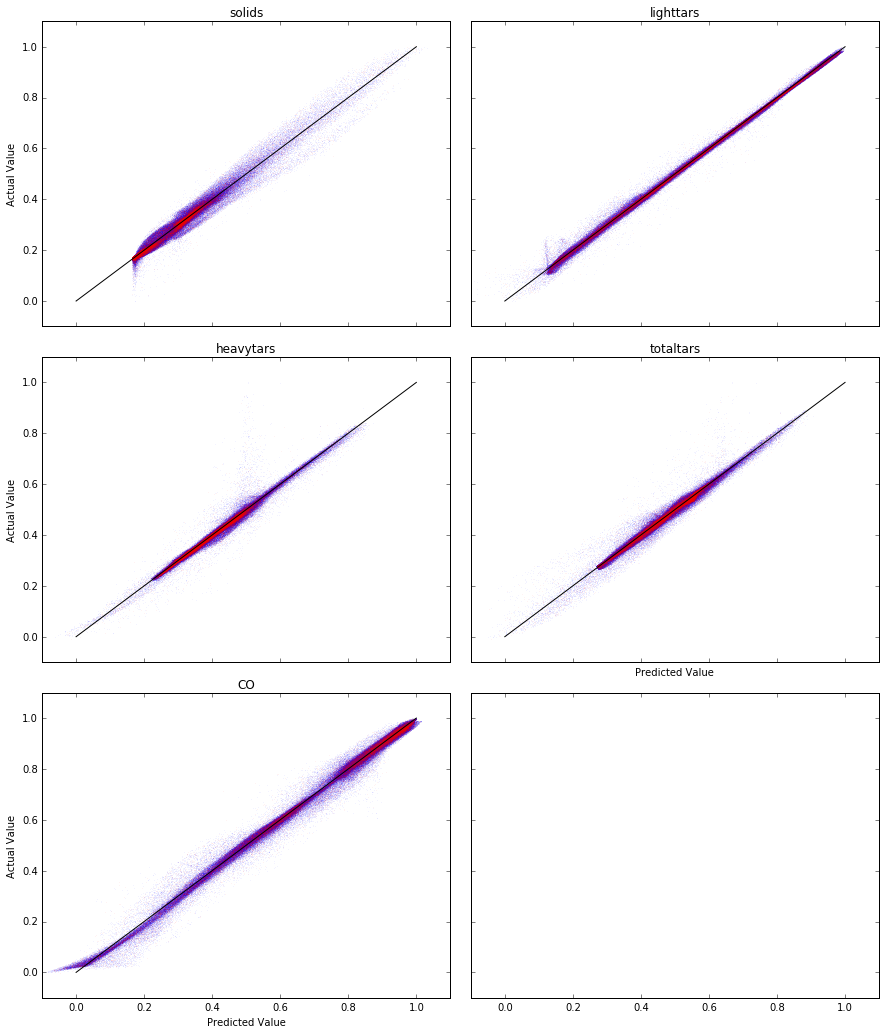

In [8]:
def pplot_one_output(y_predictions, y_predictions_test, output_col, title,
                     ub=None):
    """
    Make a parity plot for the training (blue) and test (red) set predictions
    of a specific output measure.
    
    Parameters
    ----------
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    title              : string
                         The name of the output measure being plotted
    ub                 : int
                         The number of points you would like to include in plot
    
    Returns
    -------
    None
    """
    if ub is None:
        ub = y_predictions.shape[0]

    # Parity plot of the training data
    ax[output_col].scatter(y_predictions[:ub].flatten(),
                           y_train[:ub, output_col].flatten(),
                           s=0.1, alpha=0.05,
                           c='b', marker='x', label='train')
#     ax[output_col].plot([np.min(y_train), np.max(y_train)],
#                         [np.min(y_train), np.max(y_train)], c='black')
    ax[output_col].plot([0, 1], [0, 1], c='black')
    ax[output_col].scatter(y_predictions_test[:ub].flatten(),
                           y_test[:ub, output_col].flatten(),
                           s=0.1, alpha=0.05,
                           c='r', marker='x', label='test')
    ax[output_col].set_title('%s' % title)
    ax[output_col].set_xlim([-0.1, 1.1]) 
    ax[output_col].set_ylim([-0.1, 1.1])
    
    return None


output_list = net_objs.keys()
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2, sharex=True,
                     sharey=True, figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()

for key in net_objs:
    title = net_objs[key][0]
    net = net_objs[key][1]
    y_predictions = net.predict(x_train)
    y_predictions_test = net.predict(x_test)
    pplot_one_output(y_predictions, y_predictions_test, key, title)

ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.1, wspace=0.05)
    

In [10]:
from sklearn.metrics import r2_score

r_squared = {}
for key in net_objs:
    net = net_objs[key][1]
    title = net_objs[key][0]
    y_predictions = net.predict(x_train)
    r_squared[title] = r2_score(y_train[:, key], y_predictions[:])
r_squared

{'CO': 0.9931549818169555,
 'heavytars': 0.97762402733985954,
 'lighttars': 0.99776872584397636,
 'solids': 0.97692156275424058,
 'totaltars': 0.97773537661999821}

The loss function being used is "squared_error" (from lasagne.objectives import squared_error)  
score is mean_squared_error (from sklearn.metrics import mean_squared_error)

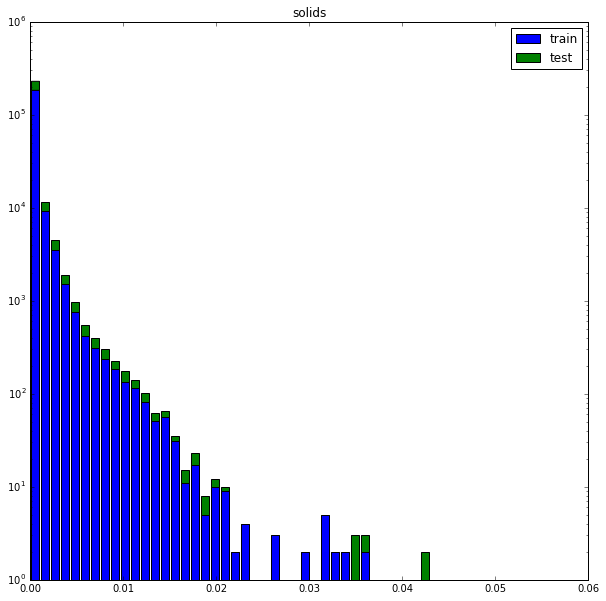

In [13]:
from sklearn.metrics import mean_squared_error

# Make a histogram for a specific output measure
output_col = 0
train_mse = []
net = net_objs[output_col][1]
y_predictions = net.predict(x_train)
for i, value in enumerate(y_train[:]):
    train_mse.append(mean_squared_error([y_train[i][output_col]],
                                        [y_predictions[i]]))
    
test_mse = []
y_predictions_test = net.predict(x_test)
for i, value in enumerate(y_test[:]):
    test_mse.append(mean_squared_error([y_test[i][output_col]],
                                       [y_predictions_test[i]]))

plt.figure(300, figsize=(10, 10))
plt.hist([train_mse, test_mse], bins=50, stacked=True, label=['train', 'test'],
         log=True)
plt.legend(loc=0)
plt.title('%s' % y_columns[output_col])


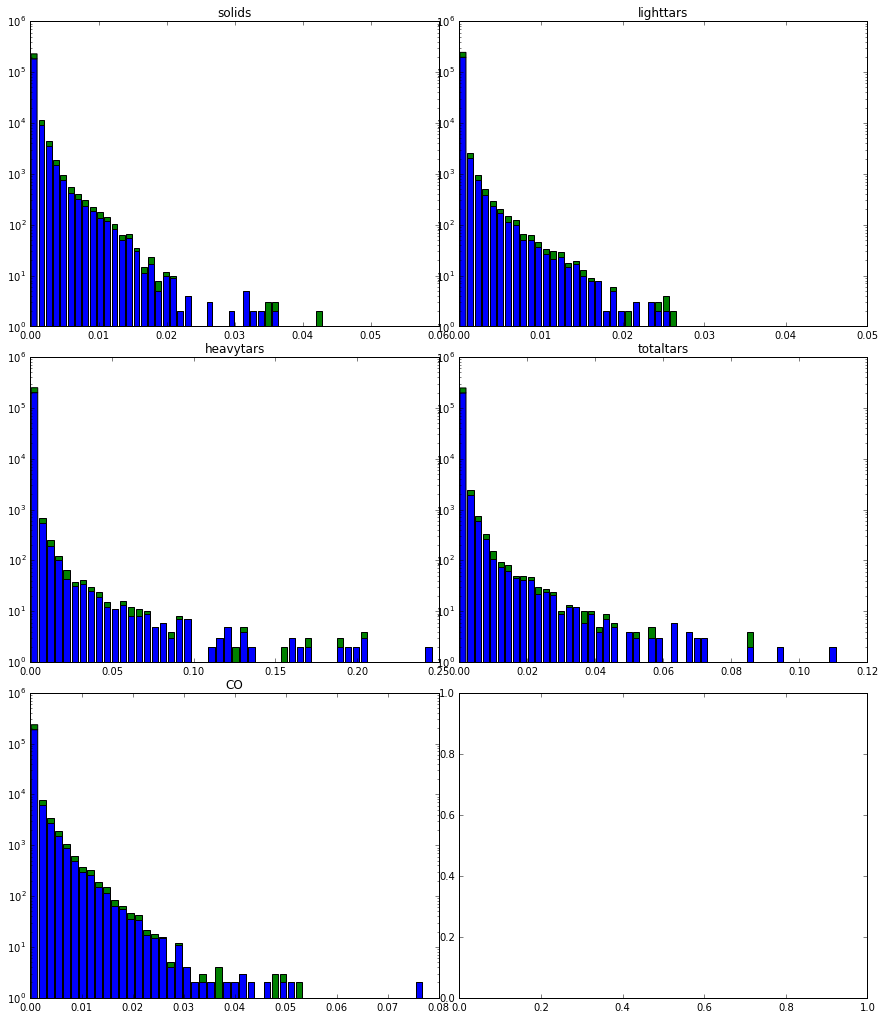

In [16]:
def hplot_one_output(y_train, y_test, y_predictions,
                     y_predictions_test, output_col):
    """
    Make a histogram for the training (blue) and test (green)
    MSEs of a specific output measure.
    
    Parameters
    ----------
    y_train            : numpy ndarray
                         The array with the training set values
    y_test             : numpy ndarray
                         The array with the test set values
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    output_col         : int
                         The column of the output measure you want to plot
    
    Returns
    -------
    None
    """
    train_mse = []
    for i, value in enumerate(y_train[:]):
        train_mse.append(mean_squared_error([y_train[i][output_col]],
                                            [y_predictions[i]]))

    test_mse = []
    for i, value in enumerate(y_test[:]):
        test_mse.append(mean_squared_error([y_test[i][output_col]],
                                           [y_predictions_test[i]]))

    ax[output_col].hist([train_mse, test_mse], bins=50, stacked=True,
                        label=['train', 'test'], log=True)
    ax[output_col].set_title('%s' % y_columns[output_col])


output_list = net_objs.keys()
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2,
                     figsize=(15, 3.5*len(output_list)))

ax = ax.ravel()
for key in net_objs:
    net = net_objs[key][1]
    y_predictions = net.predict(x_train)
    y_predictions_test = net.predict(x_test)
    hplot_one_output(y_train, y_test, y_predictions, y_predictions_test, key)
f.subplots_adjust(hspace=0.1, wspace=0.05)
    

# To do

-  figure out what the outliers are
-  we know there is some error, how to describe where the error is and what the impact is on using the model
-  benchmarking - pytest benchmark